# Day 1, after lunch: From text files to plots

We will learn how to read text files and extract relevant information. We will also create some simple plots using the python library ``matplotlib``.

## ToDo

 * test driven development
 * some examples with crafted errors
 * making use of introspection techniques? dir(), help(), etc.

In [42]:
f = open('d1s2/Dovre1-Snoheim.txt', 'r')
lines = f.readlines()
f.close()

In [43]:
print(lines[0])
print(lines[-1])

30.06.2012 14:16:00	+6.460000e+002	+7.158069e+000	+1.118880e+001	+2.454168e+002

25.08.2012 10:16:00	+6.460000e+002	+5.315732e+000	+5.439000e+000	+1.979508e+002



### Now we need to interpret all the values as numbers and dates

In [44]:
from datetime import datetime as dt
dates = []
temp = []
ff = []
dd = []
for line in lines:
    line = line.split()
    dates.append(dt.strptime(' '.join(line[:2]), '%d.%m.%Y %H:%M:%S'))
    temp.append(float(line[3]))
    ff.append(float(line[4]))
    dd.append(float(line[5]))

In [45]:
print(len(dates), dates[:5])

7806 [datetime.datetime(2012, 6, 30, 14, 16), datetime.datetime(2012, 6, 30, 14, 26), datetime.datetime(2012, 6, 30, 14, 36), datetime.datetime(2012, 6, 30, 14, 46), datetime.datetime(2012, 6, 30, 14, 56)]


### Exercise: Read and interpret the tile rro_Bulken.txt

On how many days did the runoff exceed 300 m³/s?
On how many days did the runoff exceed the climatological median flow and the 75-percentile?

In [112]:
f = open('d1s2/rro_Bulken.txt', 'r', encoding='latin1')
lines = f.readlines()
f.close()
dates = []
runoff = []
p50 = []
p75 = []
for line in lines[2:]:
    line = line.split()
    dates.append(dt.strptime(line[0], '%d%m%Y'))
    if line[2] == '----':
        line[2] = 'NaN'
    runoff.append(float(line[2]))
    p50.append(float(line[4]))
    p75.append(float(line[3]))

l = len(runoff)
print('Exceed 300 m3/s:', sum([r > 300 for r in runoff]), 'of', l)
print('Exceed median:', sum([r > m for r, m in zip(runoff, p50)]), 'of', l)
print('Exceed 75p:', sum([r > p for r, p in zip(runoff, p75)]), 'of', l)

Exceed 300 m3/s: 9 of 60
Exceed median: 52 of 60
Exceed 75p: 37 of 60


Quite repetitive! There must be a simpler solution to this.

## Reading text files using numpy.loadtxt

In [47]:
import numpy as np
data = np.loadtxt('d1s2/Dovre1-Snoheim.txt')

ValueError: could not convert string to float: '30.06.2012'

Requires some custom functions to parse the date and time.

In [48]:
from datetime import timedelta as td

DT_REF = dt(1970,1,1)
def parse_time(ibytes):
    ''' Converts a bytes object into a float representing a date and time
    
    We need to return a float instead of a datetime, as the variable type 
    within a numpy array needs to be homogeneous.
    
    To convert the date to a float, we return the number of seconds since 
    a reference time given by DT_REF.
    '''
    
    # Convert bytes to string
    istr = ibytes.decode('latin1')
    # Convert string to datetime
    date = dt.strptime(istr, '%d.%m.%Y %H:%M:%S')
    # Return number of seconds between DT_REF and date
    return (date - DT_REF).total_seconds()

def float_to_date(val):
    ''' Convert a float back to datetime 
    
    Consistently to ``parse_time'', ``val'' is expected to contain the
    number of seconds since DT_REF. We can then use the timedelta object to 
    add the given number of seconds to DT_REF and return the resulting
    ``datetime'' object.
    '''
    return DT_REF + td(0,val)

data = np.loadtxt('d1s2/Dovre1-Snoheim.txt', delimiter='\t', converters={
    0: parse_time
})
print(data.shape)
print(data[0], float_to_date(data[0,0]))

(7806, 5)
[1.34106576e+09 6.46000000e+02 7.15806900e+00 1.11888000e+01
 2.45416800e+02] 2012-06-30 14:16:00


However, manually parsing the time like shown here is quite tedious and error-prone. Fortunately, there is a more straight-forward version.

In [49]:
from matplotlib.dates import bytespdate2num, num2date
data = np.loadtxt('d1s2/Dovre1-Snoheim.txt', delimiter='\t', converters={
    0: bytespdate2num('%d.%m.%Y %H:%M:%S')
})
print(data.shape)
print(data[0], num2date(data[0,0]))

(7806, 5)
[7.34684594e+05 6.46000000e+02 7.15806900e+00 1.11888000e+01
 2.45416800e+02] 2012-06-30 14:16:00+00:00


## Plotting what we got

In [72]:
dates = [num2date(date) for date in data[:,0]]
airtemp = data[:,2]
windspeed = data[:,3]

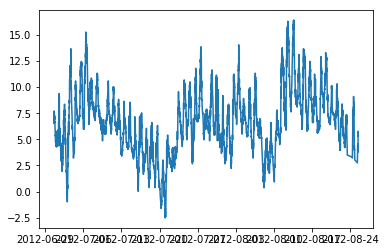

In [66]:
import matplotlib.pyplot as plt
plt.plot(dates, airtemp)
plt.show()

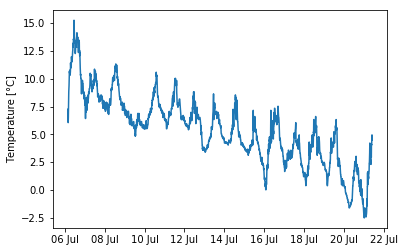

In [88]:
import matplotlib.dates as mdates
timeslice = slice(800, 3000)
plt.plot(dates[timeslice], airtemp[timeslice])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.ylabel('Temperature [°C]')
plt.show()

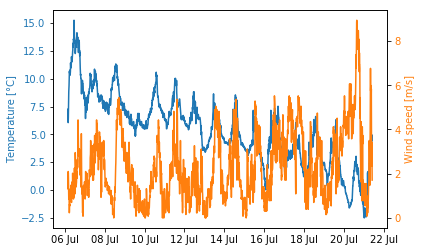

In [89]:
plt.plot(dates[timeslice], airtemp[timeslice], color='C0') # First color of the standard cycle
ax1 = plt.gca()
ax1.set_ylabel('Temperature [°C]', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = plt.twinx() # A new axes object sharing the x-axis with the original
ax2.plot(dates[timeslice], windspeed[timeslice], color='C1') # Second color of the standard cycle
ax2.set_ylabel('Wind speed [m/s]', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d %b")) # needs to be done after the twinx
plt.show()

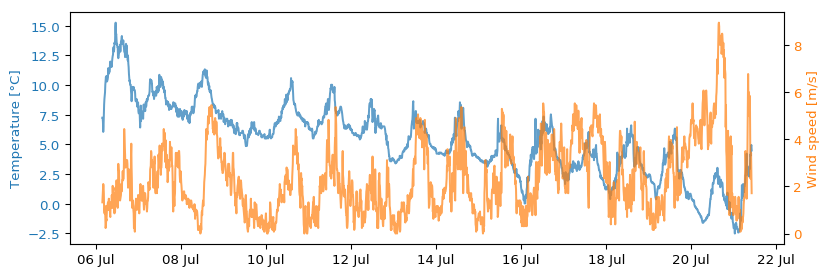

In [91]:
fig = plt.figure(figsize=(9.6, 3.2), dpi=96) # Defining the figure size 

ax1 = plt.gca()
ax1.plot(dates[timeslice], airtemp[timeslice], color='C0', alpha=0.7) # Transparency for better visibility
ax1.set_ylabel('Temperature [°C]', color='C0') 
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = plt.twinx()
ax2.plot(dates[timeslice], windspeed[timeslice], color='C1', alpha=0.7)
ax2.set_ylabel('Wind speed [m/s]', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.show()

## Exercise: Try to recreate the following plot based on the runoff data from Bulken

 * Use numpy.loadtxt to read the file and parse the dates
 * The shaded area shows the interval between the 25 and the 75 percentile
 * The functions ``plt.fill_between``, ``plt.semilogy`` and ``plt.legend`` might be helpful 

In [110]:
def missing_to_NaN(istr):
    ''' Convert a string containing a number to a float, interpreting unparsible strings as NaN '''
    
    try:
        val = float(istr)
    except ValueError:
        val = float('NaN')
    
    return val

data = np.loadtxt('d1s2/rro_Bulken.txt', encoding='latin1', converters={
    0: strpdate2num('%d%m%Y'),
    1: missing_to_NaN,
    2: missing_to_NaN,
})

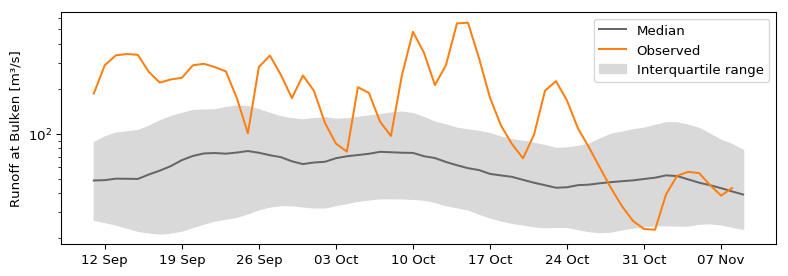

In [111]:
dates = [num2date(date) for date in data[:,0]]

fig = plt.figure(figsize=(9.6, 3.2), dpi=96)

plt.semilogy(dates, data[:,4], color='0.4', label='Median') # Median
plt.semilogy(dates, data[:,2], color='C1', label='Observed') # The actual flow
plt.fill_between(dates, data[:,3], data[:,5], color='0.85', label='Interquartile range') # 25 and 75-percentile

plt.ylabel('Runoff at Bulken [m³/s]')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.legend()
plt.show()

### Extension of the exercise: How does that fit with observed precipitation?

Small extra challenge: Daily rainfall is defined by MetNorway between 06 UTC the preceeding day to 06 UTC of the given day. Make sure that the precipitation bars are located such along the time axis that the period in which the precipitation is observed matches the time interval covered by the bar.

In [115]:
# Manual parsing necessary, np.loadtxt does not support footers
f = open('d1s2/rr24_Bulken.txt', encoding='utf8')
lines = f.readlines()
f.close()

dates_start = [] # beginning of the observation intervals
daily_precip = [] # observed values
# Skip 21 header rows and 12 footer rows
for row in lines[21:-12]:
    row = row.split()
    date_given = dt.strptime(row[1], '%d.%m.%Y')
    dates_start.append(date_given - td(0.75))
    daily_precip.append(float(row[2]))

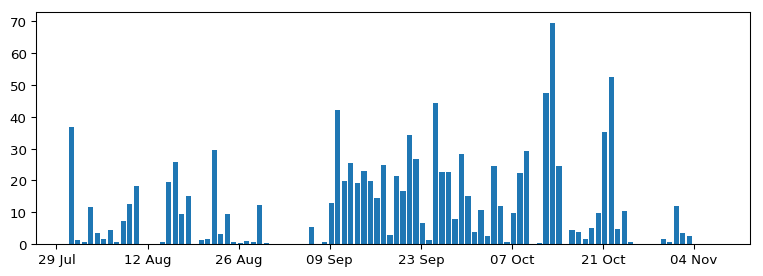

In [135]:
# First a quick and dirty plot of the precipitation during this period
fig = plt.figure(figsize=(9.6, 3.2), dpi=96)
plt.bar(dates_start, daily_precip, width=0.8)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.show()

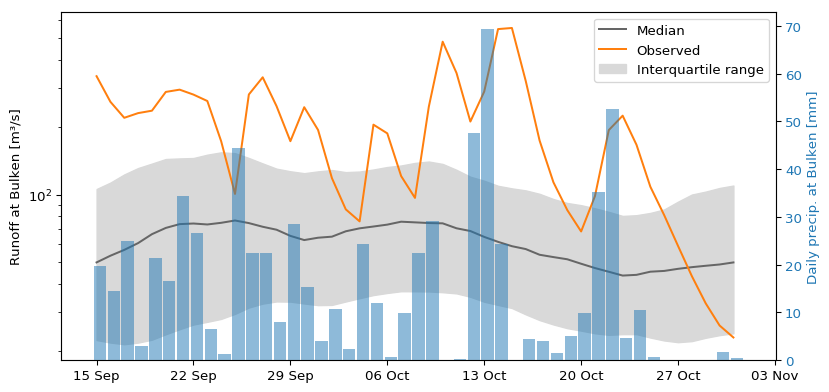

In [133]:
# Then combining everything together, considering the period 15 September - 31 October
mask_precip = np.array([date >= dt(2018,9,15) and date < dt(2018,11,1) for date in dates_start], dtype='bool')
mask_runoff = np.array([date >= dt(2018,9,15) and date < dt(2018,11,1) for date in dates], dtype='bool')
dates = np.array(dates)
dates_start = np.array(dates_start)
daily_precip = np.array(daily_precip)

fig = plt.figure(figsize=(9.6, 4.8), dpi=96)

plt.semilogy(dates[mask_runoff], data[mask_runoff,4], color='0.4', label='Median') # Median
plt.semilogy(dates[mask_runoff], data[mask_runoff,2], color='C1', label='Observed') # The actual flow
plt.fill_between(dates[mask_runoff], data[mask_runoff,3], data[mask_runoff,5], color='0.85', label='Interquartile range') # 25 and 75-percentile
plt.ylabel('Runoff at Bulken [m³/s]')
plt.legend(loc='upper right')

ax2 = plt.twinx()
ax2.bar(dates_start[mask_precip], daily_precip[mask_precip], width=0.9, alpha=0.5, color='C0')
ax2.set_ylabel('Daily precip. at Bulken [mm]', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.show()